In [108]:
# Librerias
import numpy as np
import keras
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, Embedding, Flatten
from keras.models import Sequential
from keras.layers import Flatten
import keras_tuner

Se leen los datos del .csv

In [141]:
#Inicializar y abrir archivo
corpus=[]
dic_diag={}
dic_proc={}
dic_grd={}
archivo=open("dataset_elpino.csv",encoding="utf-8")

#Sacar las variables (features o característica)
header=archivo.readline().strip().split(";")
features=[]
for col in header:
    if col.startswith("Diag") or col.startswith("Proc"):
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col)

#Sacar la data (deja sólo los códigos en el corpus y en diccionario las descripciones)
for linea in archivo:
    row=[]
    linea=linea.strip().split(";")
    for i in range(len(linea)):
        cod=linea[i].split("-")[0].strip()
        if len(linea[i].split("-")) == 2:
            des=linea[i].split("-")[1].strip()
        if i < 35:
            dic_diag[cod]=des
        elif i < 65:
            dic_proc[cod]=des
        elif i == 67:
            dic_grd[cod]=des
        elif i==66:
            cod = 1 if cod=="Mujer" else 0
        row.append(cod)
    corpus.append(row)

#Crear un dataframe con la data
df = pd.DataFrame(corpus, columns=features)
df.head(10)

,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,Edad en años,Sexo (Desc),GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.84,88.72,90.42,90.52,91.39,91.33,87.03,40,0,184103
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.62,90.43,91.39,90.52,91.32,96.59,90.99,53,0,041013
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,99.84,91.73,90.53,99.26,89.39,89.66,89.65,65,0,041013
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,57.94,00.13,00.17,99.04,99.18,99.21,99.23,61,0,041023
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,90.52,91.39,91.32,93.90,99.15,96.59,45.13,30,0,041023
5,U07.1,J12.8,R06.0,R50.9,R53,R05,Z29.0,Z01.7,J96.00,J80,...,57.94,00.17,89.39,96.6,99.26,91.82,90.99,49,1,041013
6,U07.1,J12.8,R06.0,R05,Z29.0,Z01.7,J96.09,J80,J15.1,A41.8,...,91.32,99.18,93.94,99.21,00.17,99.29,99.19,55,0,041013
7,U07.1,J12.8,J96.09,J80,R06.0,R50.9,R05,M79.19,Z29.0,Z01.7,...,99.17,99.18,99.19,99.21,99.23,99.26,99.29,33,1,041013
8,U07.1,J12.8,J80,Z20.8,Z29.0,Z01.7,T81.4,Y83.6,K85.9,K65.0,...,99.04,99.18,99.19,99.21,99.26,99.29,93.01,37,1,041023
9,U07.1,J12.8,J96.00,R50.9,R11,R05,M79.19,R07.0,A09.9,Z29.0,...,99.26,99.29,93.01,93.09,93.11,93.12,93.13,59,0,041023


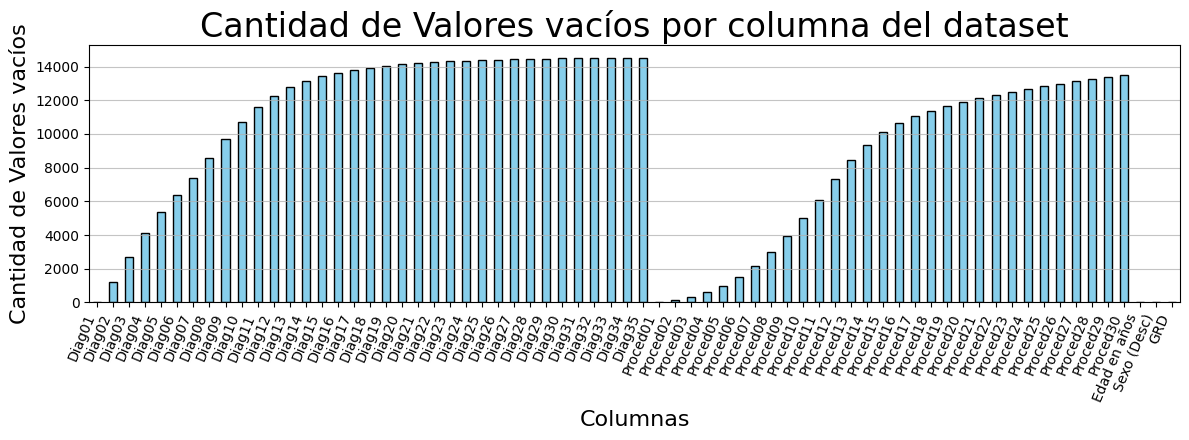

In [220]:
# Calcular la cantidad de valores '' en las primeras 65 columnas
valores_vacios_str = (df.iloc[:, :] == '').sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 4.5))
valores_vacios_str.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cantidad de Valores vacíos por columna del dataset', fontsize=24)
plt.xticks(rotation=22.5+45, ha='right')
plt.xlabel('Columnas', fontsize=16)
plt.ylabel('Cantidad de Valores vacíos', fontsize=16)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [213]:
(df.iloc[:, :] == '').sum()[36]

C:\Users\bobaz\AppData\Local\Temp\ipykernel_10216\48245591.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.iloc[:, :] == '').sum()[36]


np.int64(134)

Rango Intercuartílico (IQR): 37.0


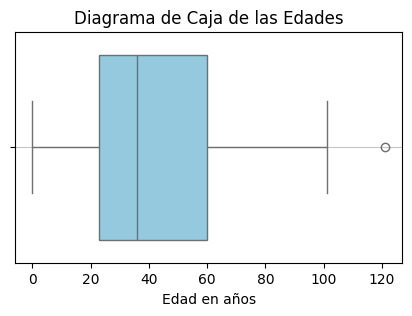

In [130]:
# Calcular el rango intercuartílico
q1 = df['Edad en años'].astype(int).quantile(0.25)
q3 = df['Edad en años'].astype(int).quantile(0.75)
iqr = q3 - q1
print(f"Rango Intercuartílico (IQR): {iqr}")

# Diagrama de caja
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['Edad en años'].astype(int), showfliers=True, color='skyblue')
plt.title('Diagrama de Caja de las Edades')
plt.xlabel('Edad en años')
plt.grid(axis='y', alpha=0.75)
plt.show()

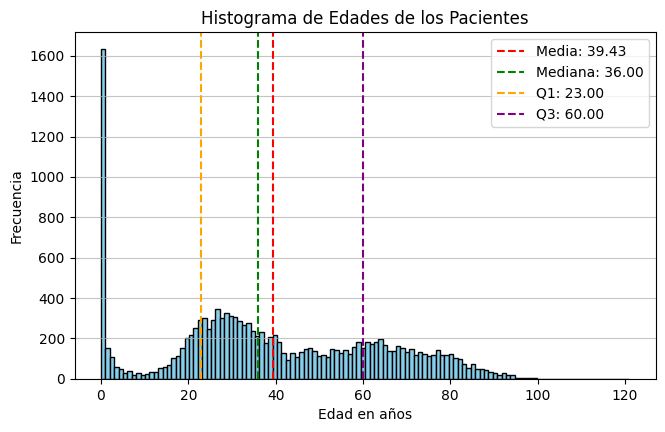

In [131]:
# Calcular estadísticas
media = df['Edad en años'].astype(int).mean()
mediana = df['Edad en años'].astype(int).median()
q1 = df['Edad en años'].astype(int).quantile(0.25)
q3 = df['Edad en años'].astype(int).quantile(0.75)

# Crear el histograma
plt.figure(figsize=(7.5, 4.5))
plt.hist([int(i) for i in df['Edad en años']], bins=120, color='skyblue', edgecolor='black')
plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='purple', linestyle='--', label=f'Q3: {q3:.2f}')
plt.title('Histograma de Edades de los Pacientes')
plt.xlabel('Edad en años')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

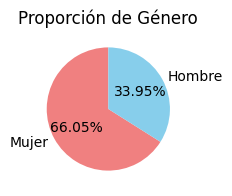

In [166]:
# Calcular la proporción de género
proporcion_genero = df['Sexo (Desc)'].value_counts(normalize=True) * 100

# Crear un gráfico de torta para la proporción de género
plt.figure(figsize=(2,2))
proporcion_genero.index = ['Mujer', 'Hombre']  # Cambiar las etiquetas
proporcion_genero.plot(kind='pie', autopct='%1.2f%%', colors=['lightcoral', 'skyblue'], startangle=90)
plt.title('Proporción de Género')
plt.ylabel('')  # Eliminar la etiqueta del eje Y
plt.show()


C:\Users\bobaz\AppData\Local\Temp\ipykernel_10216\2604179658.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axhline(clases_acumulado[clases_80], color='red', linestyle='--', label='80% de las instancias')


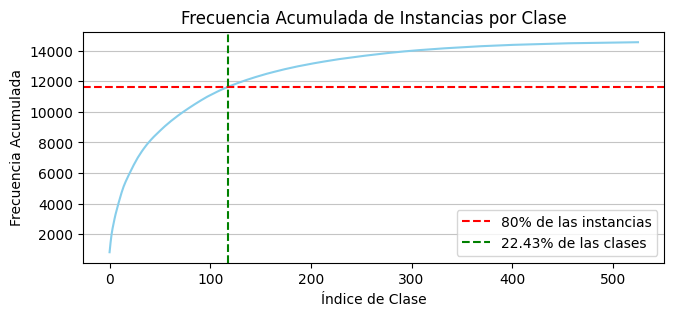

In [214]:
# Contar la cantidad de instancias por clase en la columna GRD
cantidad_por_clase = df['GRD'].value_counts()

# Calcular el porcentaje acumulado de instancias por clase
clases_acumulado = cantidad_por_clase.cumsum()

# Encontrar el número de clases necesarias para acumular el 80% de las instancias
clases_80 = (clases_acumulado  / cantidad_por_clase.sum() <= 0.8).sum()

# Crear el gráfico acumulativo
plt.figure(figsize=(7.5, 3))
plt.plot(clases_acumulado.values, color='skyblue')
plt.axhline(clases_acumulado[clases_80], color='red', linestyle='--', label='80% de las instancias')
plt.axvline(clases_80, color='green', linestyle='--', label=f'{100*clases_80/len(cantidad_por_clase):.2f}% de las clases')
plt.title('Frecuencia Acumulada de Instancias por Clase')
plt.xlabel('Índice de Clase')
plt.ylabel('Frecuencia Acumulada')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
# Seleccionar las columnas relevantes para el gráfico
diag_grd_data = df.groupby(['Diag01', 'GRD']).size().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
diag_grd_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Relación entre Diagnósticos y GRDs')
plt.xlabel('Diagnósticos')
plt.ylabel('Cantidad')
plt.legend(title='GRD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

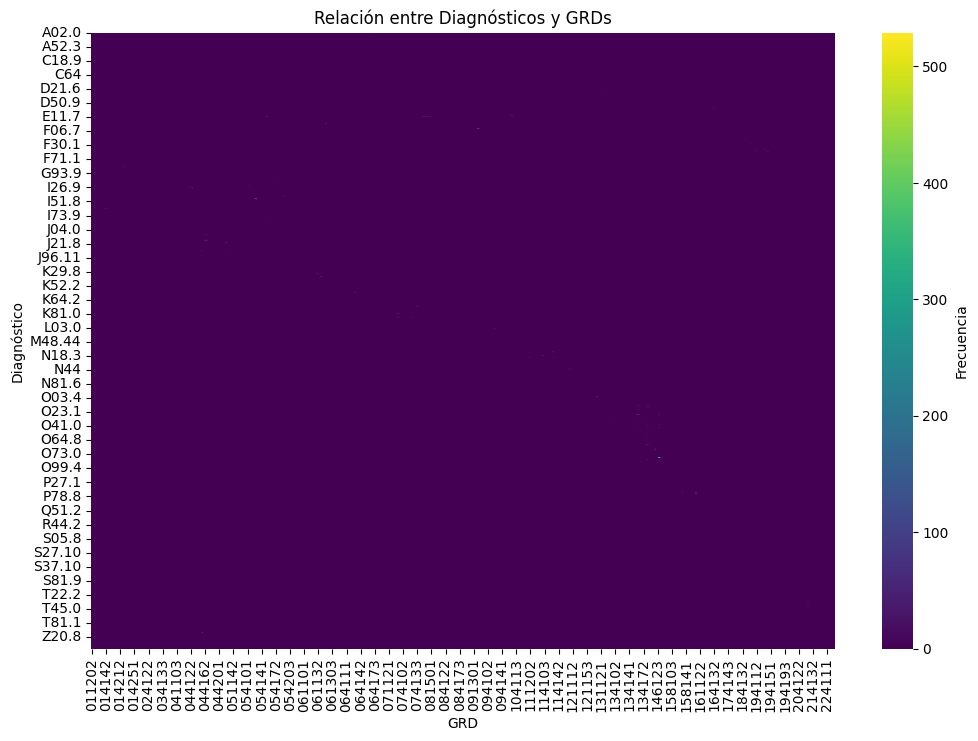

In [194]:
# Graficar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(diag_grd_data, cmap="viridis", cbar_kws={'label': 'Frecuencia'})
plt.title("Relación entre Diagnósticos y GRDs")
plt.xlabel("GRD")
plt.ylabel("Diagnóstico")
plt.show()

In [39]:
# Crear los grupos etáreos
df['Grupo Etáreo'] = pd.qcut(df['Edad en años'].astype(int), q=10, labels=[f'Grupo {i+1}' for i in range(10)])
for i in df['Grupo Etáreo'].value_counts().keys():
    print(i, df['Grupo Etáreo'].value_counts()[i]/len(df)*100)
df = df.drop(columns=['Edad en años'], axis=1)

Grupo 1 11.22862440766431
Grupo 3 10.960785660325527
Grupo 5 10.885241398255614
Grupo 8 10.205343039626399
Grupo 10 9.848224709841356
Grupo 7 9.83448938946501
Grupo 9 9.655930224572488
Grupo 6 9.360620836481012
Grupo 2 9.195796991964837
Grupo 4 8.824943341803447


In [ ]:
df["GRD"].value_counts().values[327]

np.int64(4)

Se simplifican en códigos

In [40]:
columnas_relevantes = ["Diag01", "Proced01", "Grupo Etáreo", "Sexo (Desc)", "GRD"]
df = df[columnas_relevantes]

Hay que eliminar las clases que tienen menos de 5 elementos

In [83]:
filtro_lst = list(dict(df["GRD"].value_counts()[:]).keys())[:list(df["GRD"].value_counts().values).index(4)]
filtro={filtro_lst[j]: [1 if (filtro_lst[j] == i) else 0 for i in filtro_lst] for j in range(len(filtro_lst))}

# Crear los X's y los Y's
seed=12122008
X=[]
Y=[]
vocabulario={}
for linea in range(len(df)):
    message=[]
    if df["GRD"][linea] in filtro.keys():
        for j in df.iloc[linea]:
            message.append(str(j))
            if j in vocabulario:
                vocabulario[j]+=1
            else:
                vocabulario[j]=1
        X.append(message)
        Y.append(filtro[df["GRD"][linea]])

# Tokenizar el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
words=list(tokenizer.word_index.keys())

vocabulary=len(words)+1
X = sequences
# Convertir los 1 en 0 para que no se cuenten como palabras
sequences_array = np.array(X)
sequences_array[sequences_array == 1] = 0
X = sequences_array.tolist()

input_length=len(X[0])

X=np.asarray(X)
Y=np.asarray(Y)

In [85]:
X[0]

array([ 616, 2760, 2411,  164,  274,  335, 1514,  102, 1170, 1240,   75,
        181,  168,  108,   71,  868,  954,   14,  267,  483,  107,  269,
        214, 1573, 1171,  731,  292,  546,    0,    0,    0,    0,    0,
          0,    0,  257,  571,   56,   34,  130,   31,   82,  145,   19,
          6,    9,    7,    8,   40,   52,   33,   36,    3,   35,  228,
        228,   72,    5,   23,   68,  133,   54,   15,   87,   44,  219,
          2,  639])

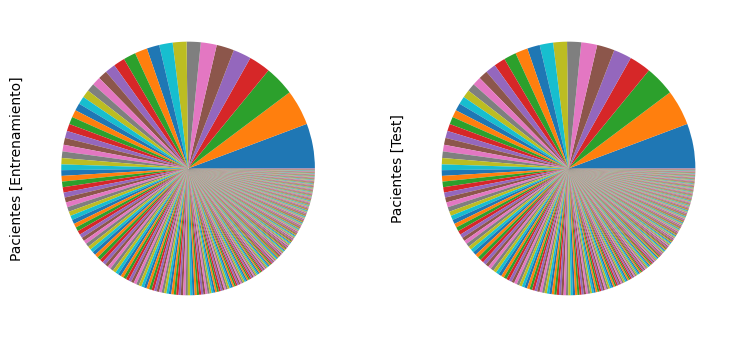

In [87]:
x_train, x_val, y_train, y_val = train_test_split(X[:-100], Y[:-100], test_size=0.2, stratify=Y[:-100], random_state=seed)
fig,ax=plt.subplots(1,2)
fig.set_size_inches(9,9)
cuantos = [np.sum(y_train[:, j]) for j in range(len(filtro_lst))]

ax[0].pie(#colors=["darkorange", "gold"],
          x=cuantos,
          #autopct=lambda x : f'{x / 100 * len(y_train):.0f}\n{x:.2f}%'
          )
ax[0].set_ylabel("Pacientes [Entrenamiento]");

ax[1].pie(#colors=["darkorange","gold"],
          x=cuantos,
          #autopct=lambda x : f'{x / 100 * len(y_val):.0f}\n{x:.2f}%'
          )
ax[1].set_ylabel("Pacientes [Test]")
plt.show()

In [93]:
def build_model(hp):
    modelo = Sequential()
    modelo.add(Embedding(input_dim=vocabulary, output_dim=64))  # Capa de Embedding
    modelo.add(Flatten())  # Aplana la salida para que sea bidimensional
    for i in range(hp.Choice("capas", [1, 2, 3])):
        modelo.add(Dense(hp.Choice("neuronas_capa", [32, 64]), activation="relu"))
    modelo.add(Dense(y_train.shape[1], activation="softmax"))  # Capa de salida con 421 clases
    modelo.compile(
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
        optimizer="adam"
    )
    return modelo

In [91]:
y_train.shape

(11228, 327)

In [94]:
tuner=keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_acc",direction="max"),
    max_trials=32,
    executions_per_trial=1,
    overwrite=True,
    directory="modelos",
    project_name="reprobacion"
)

In [95]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
capas (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
neuronas_capa (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}


In [66]:
len(y_train[0])

327

In [96]:
tuner.search(x_train,y_train,epochs=8,validation_data=(x_val,y_val),batch_size=32,verbose=1)

Trial 6 Complete [00h 00m 35s]
val_acc: 0.9946562051773071

Best val_acc So Far: 0.9964374899864197
Total elapsed time: 00h 03m 51s


In [74]:
mejor_modelo=tuner.get_best_models()[0]
mejor_modelo.summary()

c:\Users\bobaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 68, 64)         │       307,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       278,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 327)            │        21,255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,911 (2.33 MB)

 Trainable params: 611,911 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
y_pred_probs=mejor_modelo.predict(x_val)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [80]:
x_val[0]

array([  69,   47,  624,   25,   24,   21,   22,   20,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   43,   65,  305,   62,   53,   10,    3,    7,   27,
         46,   28,  319,   95,    5,   23,    6,    8,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  148,
          2, 1529])

In [102]:
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=np.argmax(y_val,axis=1)
sum(y_pred == y_true) / len(y_pred) * 100

np.float64(99.85749910936943)

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import seaborn as sns
from sklearn.preprocessing import label_binarize

In [77]:
# Para multiclase, selecciona la clase con la mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Convertir one-hot encoding a clases

sum(y_pred == y_val_classes)

np.int64(2815)

[223   9  35 ...  43  16 151]


c:\Users\bobaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 1.0, 'PR-RC Curve')

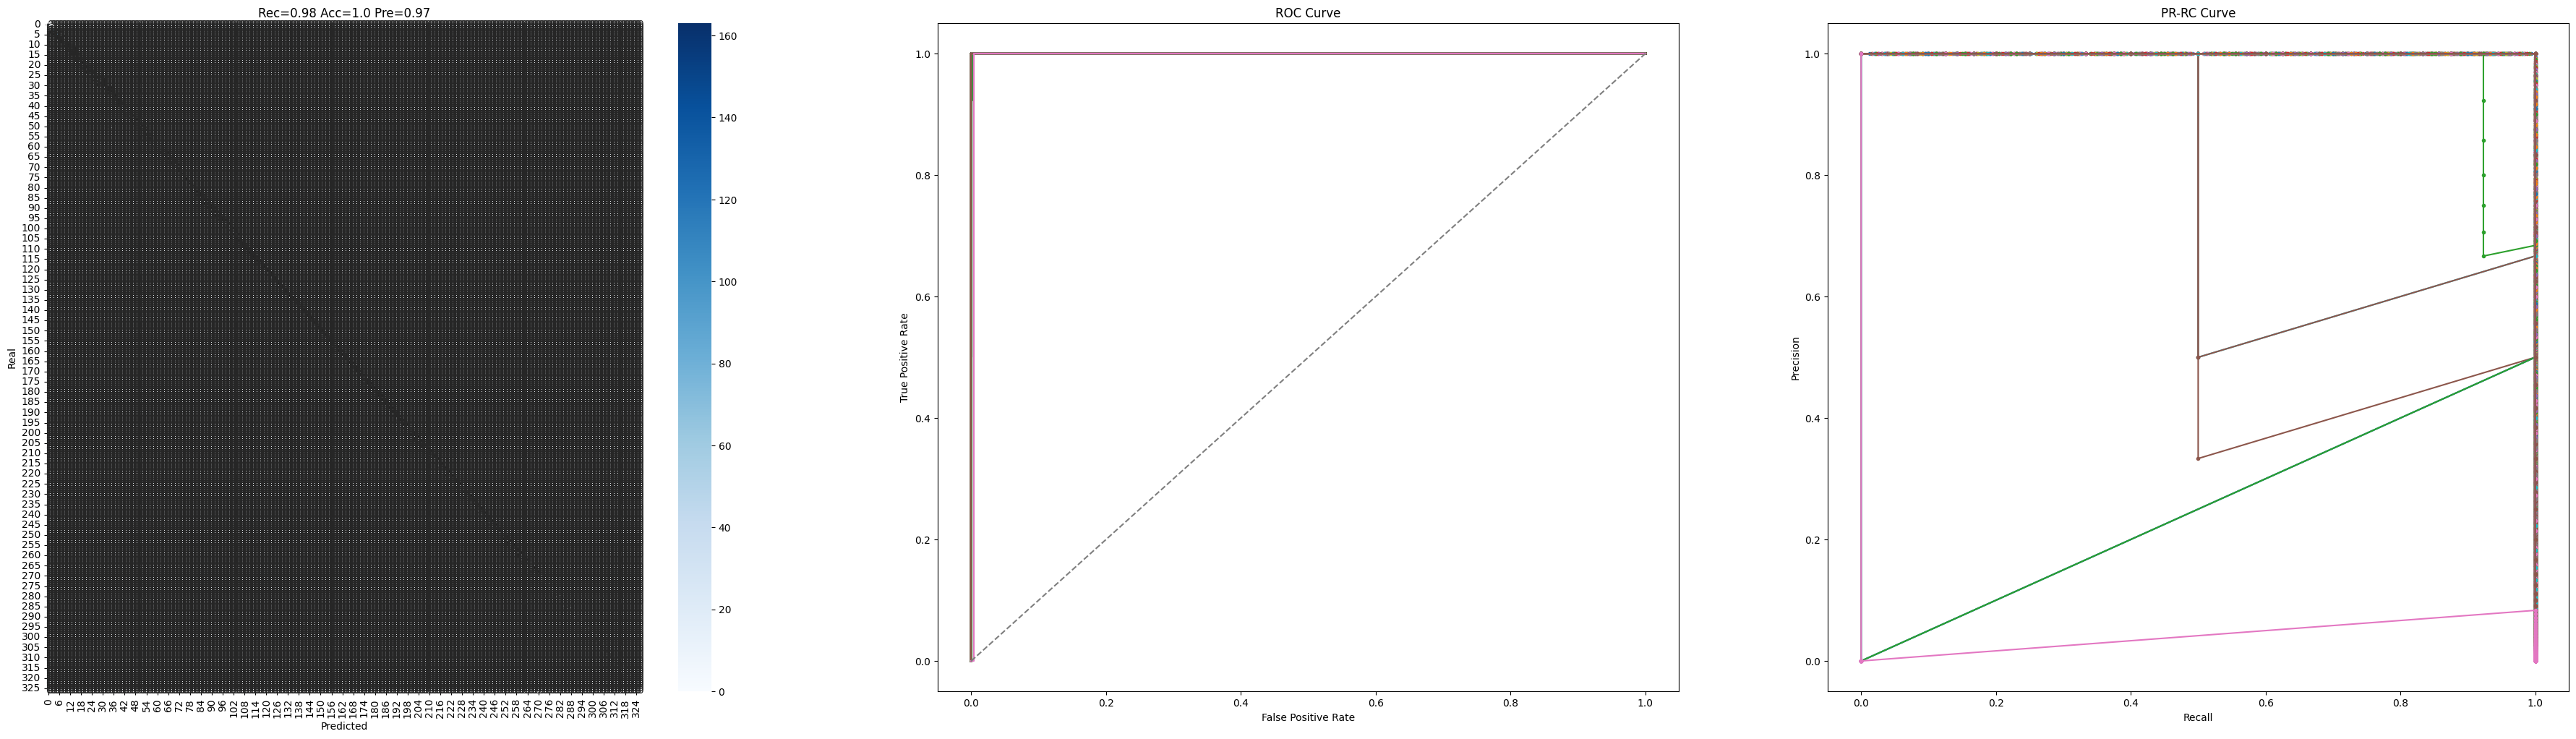

In [78]:
# Para multiclase, selecciona la clase con la mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Convertir one-hot encoding a clases

print(y_pred)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(45, 12)

# Matriz de confusión
matriz = confusion_matrix(y_val_classes, y_pred)
ax = axes[0]
sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
ax.set_title("Rec=" + str(round(recall_score(y_val_classes, y_pred, average='macro'), 2)) +
             " Acc=" + str(round(accuracy_score(y_val_classes, y_pred), 2)) +
             " Pre=" + str(round(precision_score(y_val_classes, y_pred, average='macro'), 2)))
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

# ROC Curve (requiere binarización para multiclase)
y_val_binarized = label_binarize(y_val_classes, classes=range(len(np.unique(y_val_classes))))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_val_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve para cada clase
for i in range(len(roc_auc)):
    axes[1].plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')
axes[1].plot([0, 1], [0, 1], '--', label='No Skill')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
#axes[1].legend()

# Precision-Recall Curve
lr_precision = {}
lr_recall = {}
pr_auc = {}
for i in range(y_val_binarized.shape[1]):
    lr_precision[i], lr_recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_pred_probs[:, i])
    pr_auc[i] = auc(lr_recall[i], lr_precision[i])

# Plot Precision-Recall Curve para cada clase
for i in range(len(pr_auc)):
    axes[2].plot(lr_recall[i], lr_precision[i], marker='.', label=f'Class {i} (area = {pr_auc[i]:0.2f})')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('PR-RC Curve')
#axes[2].legend()